In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from torch.optim import Adam
from torch.nn import ReLU, Linear, Softmax
from torch_geometric.nn import Sequential, GCNConv
from torch.nn.functional import nll_loss
from torch_geometric.datasets import Twitch, GitHub

In [2]:
twitch = Twitch(root="", name="RU").data
github = GitHub("").data

### Немного анализа данных перед обучением

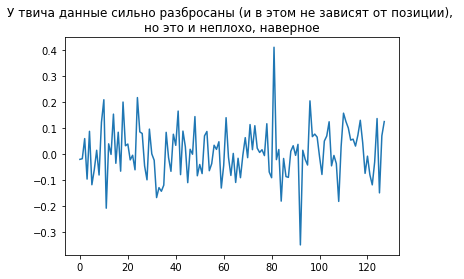

In [3]:
plt.title("У твича данные сильно разбросаны "+
          "(и в этом не зависят от позиции), \nно это и неплохо, наверное")
plt.plot(range(128), twitch.x.mean(axis=0))

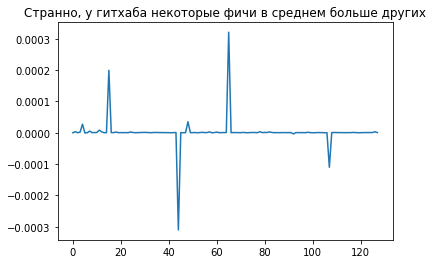

In [4]:
plt.title("Странно, у гитхаба некоторые фичи в среднем больше других")
plt.plot(range(128), github.x.mean(axis=0))

### Пара полезных функций

In [5]:
def F1(y_pred, y_true):
    precision = ((y_pred == True) & (y_true == True)).sum() / (y_pred == True).sum()
    recall = ((y_pred == True) & (y_true == True)).sum() / (y_true == True).sum()
    
    return 2 * (precision * recall) / (precision + recall)

In [6]:
def get_even_masks(y):
    # Определяем какие из классов нужно несколько раз проверять
    mask = torch.randperm(y.shape[0])
    p = y.float().mean()
    ratio = int(len(mask) * 0.8)
    train_mask, test_mask = mask[:ratio], mask[ratio:]
    
    probas = torch.ones(train_mask.shape[0]) * p
    probas[y[train_mask] == 1] = 1 - p
    idx = probas.multinomial(num_samples=train_mask.shape[0]*2, replacement=True)
    
    probas = torch.ones(mask.shape[0]) * p
    probas[y[mask] == 1] = 1 - p
    idx_total = probas.multinomial(num_samples=mask.shape[0]*2, replacement=True)
    return train_mask[idx], test_mask, mask[idx_total]
github_train_mask, github_test_mask, github_total_mask = get_even_masks(github.y)
twitch_train_mask, twitch_test_mask, twitch_total_mask = get_even_masks(twitch.y)
print("Соотношение классов:", github.y[github_train_mask].float().mean(), 
                              github.y[github_total_mask].float().mean())
print("Соотношение классов:", twitch.y[twitch_train_mask].float().mean(), 
                              twitch.y[twitch_total_mask].float().mean())

Соотношение классов: tensor(0.5057) tensor(0.4989)
Соотношение классов: tensor(0.5041) tensor(0.5000)


### Проверим, как работает катбуст на этих данных

Вот это качество на твиче...

In [7]:
clf = CatBoostClassifier(verbose=False)
clf.fit(github.x[github_train_mask].numpy(), github.y[github_train_mask].numpy())
print("github:", F1(clf.predict(github.x[github_test_mask].numpy()), 
                    github.y[github_test_mask].numpy()))
clf.fit(twitch.x[twitch_train_mask].numpy(), twitch.y[twitch_train_mask].numpy())
print("twitch:", F1(clf.predict(twitch.x[twitch_test_mask].numpy()), 
                    twitch.y[twitch_test_mask].numpy()))

github: 0.6963542941032542
twitch: 0.17270194986072424


### Проверим простую свёрточную

In [23]:
conv = lambda : Sequential('x, edge_index', [
        (GCNConv(128, 64), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GCNConv(64, 64), 'x, edge_index -> x'),
        ReLU(inplace=True),
        Linear(64, 2), 
        Softmax(dim=1)])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, data, train_mask, test_mask, device='cpu', epochs=100, verbose=False, lr=0.001):
    model =  model.to(device)
    data = data.to(device)
    model.train()
    optimizer = Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        optimizer.zero_grad()

        out = model(data.x, data.edge_index)
        loss = nll_loss(out[train_mask], data.y[train_mask])
        loss.backward()
        if verbose:
            print(F1(out[test_mask].argmax(dim=1), data.y[test_mask]))

        optimizer.step()
    out = model(data.x, data.edge_index)
    print("resulting F1=", F1(out[test_mask].argmax(dim=1), data.y[test_mask]))

print("for github:")
model_github = conv()
train(model_github, github, github_train_mask, github_test_mask, device=device)
print("for twitch:")
model_twitch = conv()
train(model_twitch, twitch, twitch_train_mask, twitch_test_mask, device=device)

for github:
resulting F1= tensor(0.7025, device='cuda:0')
for twitch:
resulting F1= tensor(0.3636, device='cuda:0')


## Пробуем катбуст на эмбеддингах модели

In [27]:
# Чтобы забрать эмбеддинги какого-то слоя надо сделать hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Сам катбуст и переносим с gpu на cpu модель и данные
clf_emb = CatBoostClassifier(depth=3, n_estimators=200, 
                             loss_function="Logloss", verbose=False)
model_github, model_twitch = model_github.cpu() ,model_twitch.cpu()
github, twitch = github.cpu(), twitch.cpu()

# Создаём хук
model_github[3].register_forward_hook(get_activation('embed_github'))
_ = model_github(github.x, github.edge_index)
embedding_github = activation["embed_github"]

# Проверяем качество
clf_emb.fit(embedding_github[github_train_mask].numpy(), github.y[github_train_mask].numpy())
print("github:", F1(clf_emb.predict(embedding_github[github_test_mask].numpy()), 
                    github.y[github_test_mask].numpy()))

# Повторяем для twitch

model_twitch[3].register_forward_hook(get_activation('embed_twitch'))
_ = model_twitch(twitch.x, twitch.edge_index)
embedding_twitch = activation["embed_twitch"]

clf_emb.fit(embedding_twitch[twitch_train_mask].numpy(), twitch.y[twitch_train_mask].numpy())
print("twitch:", F1(clf_emb.predict(embedding_twitch[twitch_test_mask].numpy()), 
                    twitch.y[twitch_test_mask].numpy()))

github: 0.7048539222452266
twitch: 0.3521126760563381


## Кросс-валидация

### Сначала github

Здесь смотрим на циферки в последней строке датафрейма снизу, нам хочется test-F1-mean -> 1 (ну и std->0)

In [28]:
from catboost import Pool, cv

cv_dataset = Pool(data=github.x.numpy(),
                  label=github.y.numpy())

params = {"iterations": 600,
          "depth": 3,
          "loss_function": "Logloss",
          "verbose": False,
         "custom_metric": "F1"}

cv(cv_dataset,
   params,
   fold_count=5, 
   plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3362405698
bestIteration = 599

Training on fold [1/5]

bestTest = 0.3428661962
bestIteration = 599

Training on fold [2/5]

bestTest = 0.3424415192
bestIteration = 599

Training on fold [3/5]

bestTest = 0.3434949652
bestIteration = 599

Training on fold [4/5]

bestTest = 0.3495692018
bestIteration = 598



,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std
0,0,0.675862,0.000129,0.675811,0.000068,0.623497,0.008230,0.624802,0.003485
1,1,0.659830,0.000174,0.659769,0.000079,0.628592,0.007473,0.629442,0.002452
2,2,0.644437,0.000287,0.644358,0.000141,0.638942,0.007761,0.640011,0.005132
3,3,0.630253,0.000313,0.630168,0.000153,0.629393,0.007177,0.631696,0.002133
4,4,0.617335,0.000698,0.617240,0.000283,0.631030,0.011338,0.632554,0.005696
...,...,...,...,...,...,...,...,...,...
595,595,0.343004,0.004702,0.331393,0.001280,0.686448,0.007462,0.698508,0.002223
596,596,0.342981,0.004701,0.331343,0.001276,0.686293,0.007443,0.698557,0.002127
597,597,0.342955,0.004719,0.331297,0.001267,0.686330,0.007555,0.698707,0.002120
598,598,0.342942,0.004718,0.331258,0.001273,0.686365,0.007599,0.698669,0.002078


In [29]:
cv_dataset = Pool(data=embedding_github.numpy(),
                  label=github.y.numpy())

params = {"iterations": 600,
          "depth": 3,
          "loss_function": "Logloss",
          "verbose": False,
         "custom_metric": "F1"}

cv(cv_dataset,
   params,
   fold_count=5, 
   plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3162290157
bestIteration = 584

Training on fold [1/5]

bestTest = 0.3241756583
bestIteration = 575

Training on fold [2/5]

bestTest = 0.3153085508
bestIteration = 588

Training on fold [3/5]

bestTest = 0.3182280012
bestIteration = 584

Training on fold [4/5]

bestTest = 0.3247960481
bestIteration = 495



,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std
0,0,0.666953,0.000709,0.666874,0.000685,0.711434,0.010791,0.712565,0.003050
1,1,0.642929,0.001069,0.642775,0.000991,0.715196,0.008919,0.716315,0.003192
2,2,0.621291,0.001170,0.621087,0.001049,0.718194,0.010761,0.720784,0.001673
3,3,0.601044,0.001763,0.600878,0.001616,0.720681,0.008709,0.722561,0.003016
4,4,0.581806,0.001269,0.581634,0.001072,0.723528,0.008106,0.724826,0.002562
...,...,...,...,...,...,...,...,...,...
595,595,0.319783,0.004470,0.308841,0.001029,0.724606,0.005830,0.735748,0.001651
596,596,0.319781,0.004470,0.308823,0.001022,0.724606,0.005830,0.735724,0.001631
597,597,0.319782,0.004468,0.308805,0.001025,0.724606,0.005830,0.735700,0.001663
598,598,0.319781,0.004465,0.308778,0.001027,0.724828,0.005928,0.735731,0.001581


### Теперь то же самое для twitch


In [30]:
cv_dataset = Pool(data=twitch.x.numpy(),
                  label=twitch.y.numpy())

params = {"iterations": 600,
          "depth": 3,
          "loss_function": "Logloss",
          "verbose": False,
         "custom_metric": "F1"}

cv(cv_dataset,
   params,
   fold_count=5, 
   plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5552819779
bestIteration = 128

Training on fold [1/5]

bestTest = 0.55427233
bestIteration = 160

Training on fold [2/5]

bestTest = 0.554533914
bestIteration = 282

Training on fold [3/5]

bestTest = 0.5524187654
bestIteration = 259

Training on fold [4/5]

bestTest = 0.5542303629
bestIteration = 204



,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std
0,0,0.684684,0.000034,0.684608,0.000021,0.000000,0.000000,0.000000,0.000000
1,1,0.676688,0.000055,0.676561,0.000039,0.000000,0.000000,0.000000,0.000000
2,2,0.669211,0.000100,0.669011,0.000039,0.000000,0.000000,0.000000,0.000000
3,3,0.662248,0.000136,0.661996,0.000046,0.000000,0.000000,0.000000,0.000000
4,4,0.655672,0.000161,0.655317,0.000123,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
595,595,0.561125,0.003367,0.470869,0.001846,0.014596,0.015277,0.133575,0.015666
596,596,0.561148,0.003374,0.470749,0.001853,0.014596,0.015277,0.134801,0.014762
597,597,0.561188,0.003372,0.470623,0.001859,0.014596,0.015277,0.135215,0.014047
598,598,0.561230,0.003416,0.470466,0.001872,0.014596,0.015277,0.135650,0.011126


In [31]:
cv_dataset = Pool(data=embedding_twitch.numpy(),
                  label=twitch.y.numpy())

params = {"iterations": 600,
          "depth": 3,
          "loss_function": "Logloss",
          "verbose": False,
         "custom_metric": "F1"}

cv(cv_dataset,
   params,
   fold_count=5, 
   plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.51994273
bestIteration = 167

Training on fold [1/5]

bestTest = 0.5211004947
bestIteration = 165

Training on fold [2/5]

bestTest = 0.5270473901
bestIteration = 108

Training on fold [3/5]

bestTest = 0.5232140441
bestIteration = 110

Training on fold [4/5]

bestTest = 0.5202549225
bestIteration = 345



,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std
0,0,0.682661,0.000158,0.682609,0.000106,0.000000,0.000000,0.000000,0.000000
1,1,0.672567,0.000095,0.672412,0.000196,0.000000,0.000000,0.000000,0.000000
2,2,0.663417,0.000188,0.663193,0.000358,0.000000,0.000000,0.000928,0.002075
3,3,0.654905,0.000267,0.654638,0.000230,0.000000,0.000000,0.000465,0.001039
4,4,0.646807,0.000502,0.646421,0.000297,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
595,595,0.530106,0.004692,0.440537,0.002921,0.089772,0.015723,0.344597,0.018864
596,596,0.530114,0.004688,0.440407,0.002899,0.089688,0.015619,0.344912,0.018971
597,597,0.530141,0.004660,0.440236,0.002909,0.089605,0.015555,0.344910,0.019055
598,598,0.530105,0.004625,0.440089,0.002920,0.091131,0.017665,0.345847,0.019641


## Итог оценки:

Из графиков кросс-валидации видно, что:
* На github использование связки GCNConv + Catboost даёт прирост в ~0.02 F1, что может быть вполне неплохо
* На twitch использование связки дало только улучшение F1, но там в целом как-то слабо вышло

## Попробуем attention

In [34]:
from torch_geometric.nn import GAT

gat = lambda : Sequential('x, edge_index', [
        (GCNConv(128, 128), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GAT(in_channels=128, hidden_channels=64, 
             out_channels=64, num_layers=1), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GCNConv(64, 32), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GCNConv(32, 16), 'x, edge_index -> x'),
        ReLU(inplace=True),
        Linear(16, 2),
        ])

In [35]:
print("for github:")
model_github = gat()
train(model_github, github, github_train_mask, github_test_mask, 
      device=device, lr=1e-4, verbose = True)
print("for twitch:")
model_twitch = gat()
train(model_twitch, twitch, twitch_train_mask, twitch_test_mask, 
      device=device, lr=1e-4, verbose = True)

for github:
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4086, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:0')
tensor(0.4087, device='cuda:

In [36]:
# Чтобы забрать эмбеддинги какого-то слоя надо сделать hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Сам катбуст и переносим с gpu на cpu модель и данные
clf_emb = CatBoostClassifier(depth=3, n_estimators=300, verbose=False)
model_github, model_twitch = model_github.cpu() , model_twitch.cpu()
github, twitch = github.cpu(), twitch.cpu()

# Создаём хук
model_github[3].register_forward_hook(get_activation('embed_github'))
_ = model_github(github.x, github.edge_index)
embedding_github = activation["embed_github"]

# Проверяем качество
clf_emb.fit(embedding_github[github_train_mask].numpy(), github.y[github_train_mask].numpy())
print("github:", F1(clf_emb.predict(embedding_github[github_test_mask].numpy()), 
                    github.y[github_test_mask].numpy()))

# Повторяем для twitch
clf_emb = CatBoostClassifier(depth=3, verbose=False)

model_twitch[3].register_forward_hook(get_activation('embed_twitch'))
_ = model_twitch(twitch.x, twitch.edge_index)
embedding_twitch = activation["embed_twitch"]

clf_emb.fit(embedding_twitch[twitch_train_mask].numpy(), twitch.y[twitch_train_mask].numpy())
print("twitch:", F1(clf_emb.predict(embedding_twitch[twitch_test_mask].numpy()), 
                    twitch.y[twitch_test_mask].numpy()))

github: 0.6531751570132589
twitch: 0.28615863141524106


## Итог

В целом хорошо, но слишком уж долго заставлял его работать

Сам по себе attention почти не обращает внимания на oversampling, из-за чего уводит F1 в nan
